<a href="https://colab.research.google.com/github/huijeong728/advanced-statistics/blob/master/20191121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Deep Dream](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/deepdream.ipynb)

This tutorial contains a minimal implementation of DeepDream, as described in this [blog post](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) by Alexander Mordvintsev.

DeepDream is an experiment that visualizes the patterns learned by a neural network. Similar to when a child watches clouds and tries to interpret random shapes, DeepDream over-interprets and enhances the patterns it sees in an image.

It does so by forwarding an image through the network, then calculating the gradient of the image with respect to the activations of a particular layer. The image is then modified to increase these activations, enhancing the patterns seen by the network, and resulting in a dream-like image. This process was dubbed "Inceptionism" (a reference to [InceptionNet](https://arxiv.org/pdf/1409.4842.pdf), and the [movie](https://en.wikipedia.org/wiki/Inception) Inception.

Let's demonstrate how you can make a neural network "dream" and enhance the surreal patterns it sees in an image.

![Dogception](images/dogception.png)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import numpy as np

import matplotlib as mpl

from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

## Choose an image to dream-ify

For this tutorial, let's use an image of a [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg).

In [0]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

90112/83281 [================================] - 0s 0us/step


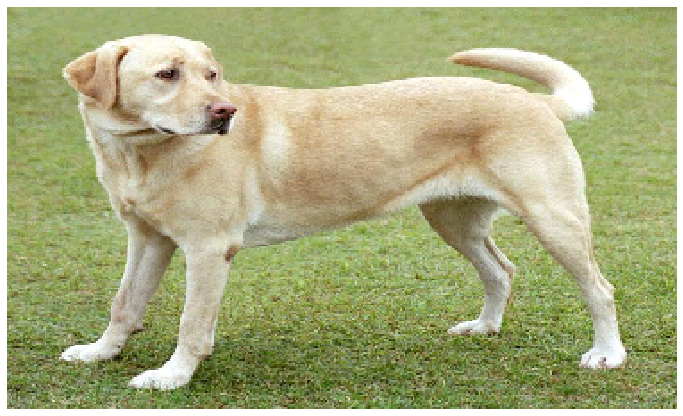

In [0]:
# Download an image and read it into a NumPy array.
def download(url, target_size=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
  return img

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)


# Display an image
def show(img):
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)
  plt.show()

# Downsizing the image makes it easier to work with.
original_img = download(url, target_size=[225, 375])
original_img = np.array(original_img)

show(original_img)

## Prepare the feature extraction model

Download and prepare a pre-trained image classification model. You will use [InceptionV3](https://keras.io/applications/#inceptionv3) which is similar to the model originally used in DeepDream. Note that any [pre-trained model](https://keras.io/applications/#models-for-image-classification-with-weights-trained-on-imagenet) will work, although you will have to adjust the layer names below if you change this.

In [0]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 3s 0us/step


The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers. The complexity of the features incorporated depends on layers chosen by you, i.e, lower layers produce strokes or simple patterns, while deeper layers give sophisticated features in images, or even whole objects.

The InceptionV3 architecture is quite large (for a graph of the model architecture see TensorFlow's [research repo](https://github.com/tensorflow/models/tree/master/research/inception)). For DeepDream, the layers of  interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Using different layers will result in different dream-like images. Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures). Feel free to experiment with the layers selected below, but keep in mind that deeper layers (those with a higher index) will take longer to train on since the gradient computation is deeper.

In [0]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalizaed at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [0]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## Gradient ascent

Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image. 

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

In [0]:
@tf.function
def deepdream(model, img, step_size):
    with tf.GradientTape() as tape:
      # This needs gradients relative to `img`
      # `GradientTape` only watches `tf.Variable`s by default
      tape.watch(img)
      loss = calc_loss(img, model)

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    gradients = tape.gradient(loss, img)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 
    
    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    img = img + gradients*step_size
    img = tf.clip_by_value(img, -1, 1)

    return loss, img

In [0]:
def run_deep_dream_simple(model, img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  for step in range(steps):
    loss, img = deepdream(model, img, step_size)
    
    if step % 100 == 0:
      clear_output(wait=True)
      show(deprocess(img))
      print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  clear_output(wait=True)
  show(result)

  return result

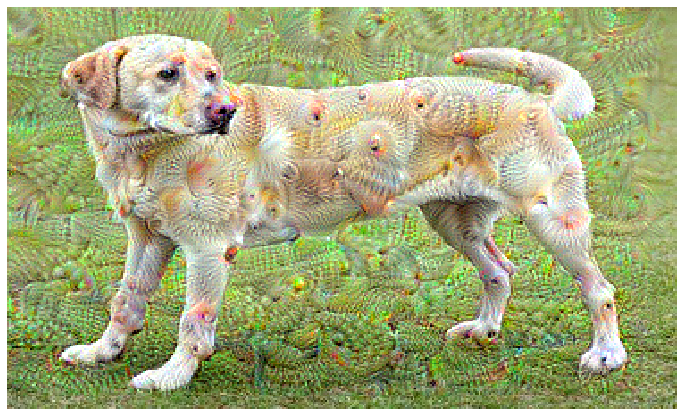

In [0]:
dream_img = run_deep_dream_simple(model=dream_model, img=original_img, 
                                  steps=800, step_size=0.001)

## Taking it up an octave

Pretty good, but there are a few issues with this first attempt: 

  1. The output is noisy (this could be addressed with a `tf.image.total_variation` loss).
  1. The image is low resolution.
  1. The patterns appear like they're all happening at the same granularity.
  
One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this you can perform the previous gradient ascent approach, then increase the size of the image (which is reffered to as an octave), and repeat this process for multiple octaves.



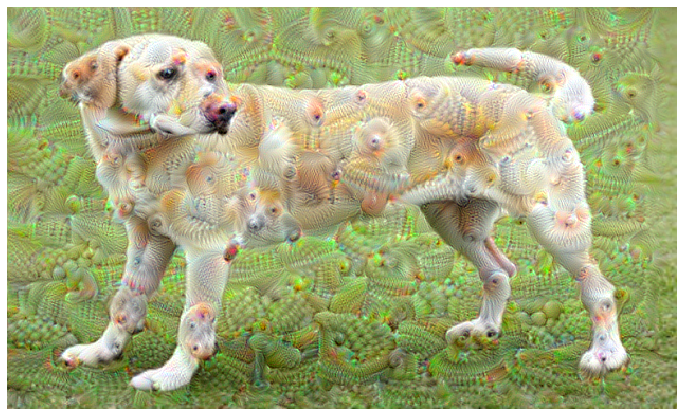

In [0]:
OCTAVE_SCALE = 1.3

img = tf.constant(np.array(original_img))
base_shape = tf.cast(tf.shape(img)[:-1], tf.float32)

for n in range(3):
  new_shape = tf.cast(base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(model=dream_model, img=img, steps=200, step_size=0.001)

clear_output(wait=True)
show(img)

## Scaling up with tiles

One thing to consider is that as the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves.

To avoid this issue you can split the image into tiles and compute the gradient for each tile.

Applying random shifts to the image before each tiled computation prevents tile seams from appearing.

Start by implementing the random shift:

In [0]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

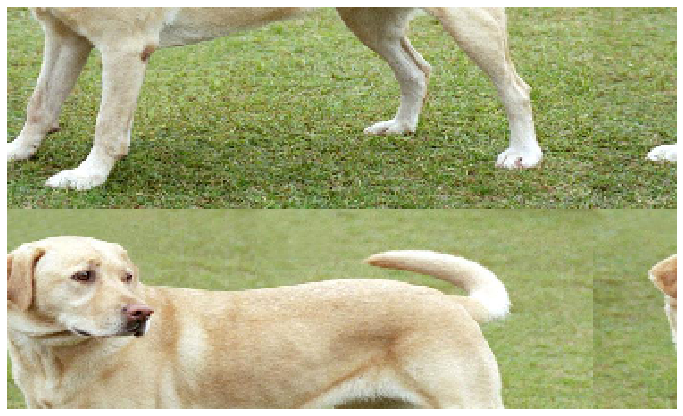

In [0]:
shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

Here is a tiled equivalent of the `deepdream` function defined earlier:

In [0]:
@tf.function
def get_tiled_gradients(model, img, tile_size=512):
  shift_down, shift_right, img_rolled = random_roll(img, tile_size)

  # Initialize the image gradients to zero.
  gradients = tf.zeros_like(img_rolled)

  for x in tf.range(0, img_rolled.shape[0], tile_size):
    for y in tf.range(0, img_rolled.shape[1], tile_size):
      # Calculate the gradients for this tile.
      with tf.GradientTape() as tape:
        # This needs gradients relative to `img_rolled`.
        # `GradientTape` only watches `tf.Variable`s by default.
        tape.watch(img_rolled)

        # Extract a tile out of the image.
        img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
        loss = calc_loss(img_tile, model)

      # Update the image gradients for this tile.
      gradients = gradients + tape.gradient(loss, img_rolled)

  # Undo the random shift applied to the image and its gradients.
  gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

  # Normalize the gradients.
  gradients /= tf.math.reduce_std(gradients) + 1e-8 

  return gradients 

Putting this together gives a scalable, octave-aware deepdream implementation:

In [0]:
def run_deep_dream_with_octaves(model, img, steps_per_octave=100, step_size=0.01, 
                                num_octaves=3, octave_scale=1.3):
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  for octave in range(num_octaves):
    # Scale the image based on the octave
    if octave>0:
      new_size = tf.cast(tf.convert_to_tensor(img.shape[:2]), tf.float32)*octave_scale
      img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(model, img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  clear_output(wait=True)
  result = deprocess(img)
  show(result)

  return result

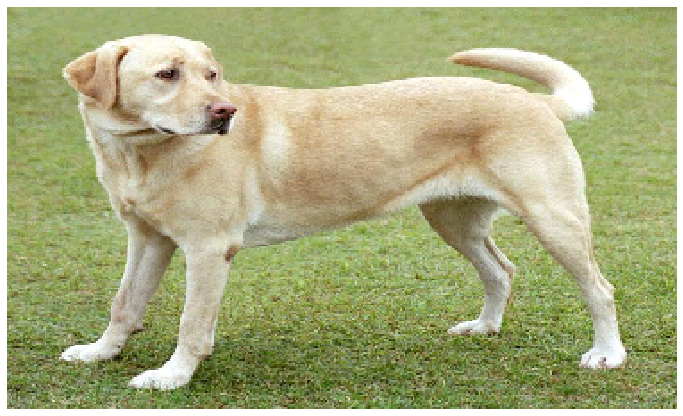

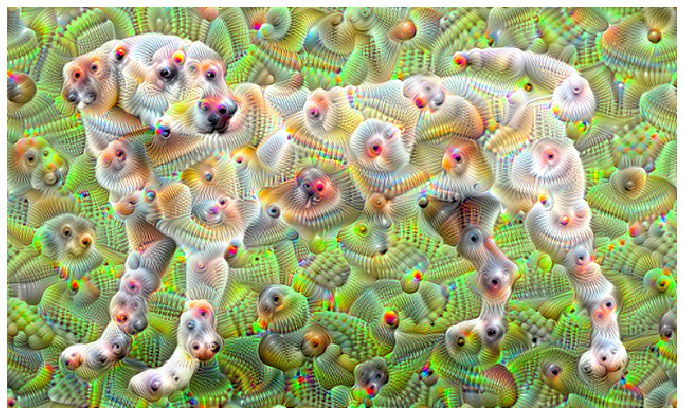

In [0]:
dream_img = run_deep_dream_with_octaves(model=dream_model, img=original_img, step_size=0.01)

clear_output()
show(original_img)
show(dream_img)

Much better! Play around with the number of octaves, octave scale, and activated layers to change how your DeepDream-ed image looks.

Readers might also be interested in [TensorFlow Lucid](https://github.com/tensorflow/lucid) which expands on ideas introduced in this tutorial to visualize and interpret neural networks.

# [심층 합성곱 생성적 적대 신경망](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/ko/tutorials/generative/dcgan.ipynb)

Note: 이 문서는 텐서플로 커뮤니티에서 번역했습니다. 커뮤니티 번역 활동의 특성상 정확한 번역과 최신 내용을 반영하기 위해 노력함에도 불구하고 공식 영문 문서의 내용과 일치하지 않을 수 있습니다. 이 번역에 개선할 부분이 있다면 [tensorflow/docs](https://github.com/tensorflow/docs) 깃헙 저장소로 풀 리퀘스트를 보내주시기 바랍니다. 문서 번역이나 리뷰에 참여하려면 [docs-ko@tensorflow.org](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ko)로 메일을 보내주시기 바랍니다.

이 튜토리얼은 [심층 합성곱 생성적 적대 신경망](https://arxiv.org/pdf/1511.06434.pdf) (Deep Convolutional Generative Adversarial Networks, DCGAN)을 이용하여, 손으로 쓴 숫자들을 어떻게 생성할 수 있는지 보여줍니다. 이 코드는 [케라스 Sequential API](https://www.tensorflow.org/guide/keras)와 `tf.GradientTape` 훈련 루프를 사용하여 작성됐습니다.

## 생성적 적대 신경망(GANs)은 무엇인가요? 

[생성적 적대 신경망](https://arxiv.org/abs/1406.2661) (Generative Adversarial Networks, GANs)은 요즘 컴퓨터 과학에서 가장 흥미로운 아이디어 중 하나입니다. 두개의 모델이 적대적인 과정을 통해 동시에 훈련됩니다. *생성자* ("예술가")는 진짜처럼 보이는 이미지를 생성하도록 배우는 와중에, *감별자* ("예술비평가")는 가짜의 이미지로부터 진짜를 구별하게 되는 것을 배우게 됩니다.

![생성자와 감별자를 그린 도표](https://tensorflow.org/tutorials/generative/images/gan1.png)



훈련과정 동안 *생성자*는 점차 실제같은 이미지를 더 잘 생성하게 되고, *감별자*는 점차 진짜와 가짜를 더 잘 구별하게됩니다. 이 과정은 *감별자*가 가짜 이미지에서 진짜 이미지를 더이상 구별하지 못하게 될때, 평형상태에 도달하게 됩니다. 

![생성자와 감별자를 그린 두번째 도표](https://tensorflow.org/tutorials/generative/images/gan2.png)

이 노트북은 이 과정을 MNIST 데이터를 이용하여 보여줍니다. 아래의 애니메이션은 50 에포크(epoch)동안 훈련한 *생성자*가 생성해낸 연속된 이미지들을 보여줍니다. 이미지들은 랜덤한 잡음으로 부터 시작되었고, 점차 시간이 지남에 따라 손으로 쓴 숫자들을 닮아가게 됩니다.

![출력 예시](https://tensorflow.org/images/gan/dcgan.gif)

생성적 적대 신경망 (GANs)에 대해 더 배우고 싶으시다면, MIT의 [Intro to Deep Learning](http://introtodeeplearning.com/) 수업을 추천합니다.

### 텐서플로와 다른 라이브러리 불러오기

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
!pip install tensorflow-gpu==2.0.0-rc1

In [0]:
import tensorflow as tf

In [0]:
tf.__version__

'2.0.0'

In [0]:
# GIF를 만들기위해 설치합니다.
!pip install imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### 데이터셋 로딩 및 준비
생성자와 감별자를 훈련하기위해 MNIST 데이터셋을 사용할것입니다. 생성자는 손글씨 숫자 데이터를 닮은 숫자들을 생성할 것입니다. 

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 모델 만들기 
생성자와 감별자는 [케라스 Sequential API](https://www.tensorflow.org/guide/keras#sequential_model)를 이용해 정의됩니다. 

### 생성자

생성자는 시드값 (seed; 랜덤한 잡음)으로부터 이미지를 생성하기 위해, `tf.keras.layers.Conv2DTranspose` (업샘플링) 층을 이용합니다. 처음 `Dense`층은 이 시드값을 인풋으로 받습니다. 그 다음 원하는 사이즈 28x28x1의 이미지가 나오도록 업샘플링을 여러번 합니다. tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 `tf.keras.layers.LeakyReLU`을 사용하고 있음을 주목합시다.

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

(아직 훈련이 되지않은) 생성자를 이용해 이미지를 생성해봅시다. 

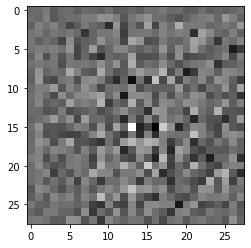

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 감별자 
감별자는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기입니다. 

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

(아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별합니다. 모델은 진짜 이미지에는 양수의 값 (positive values)을, 가짜 이미지에는 음수의 값 (negative values)을 출력하도록 훈련되어집니다.

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00036013]], shape=(1, 1), dtype=float32)


## 손실함수와 옵티마이저 정의
두 모델의 손실함수와 옵티마이저를 정의합니다. 

In [0]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 감별자 손실함수

이 메서드는 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 생성자 손실함수

생성자의 손실함수는 감별자를 얼마나 잘 속였는지에 대해 수치화를 합니다. 직관적으로 생성자가 원활히 수행되고 있다면, 감별자는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것입니다. 여기서 우리는 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교를 할 것입니다. 

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

감별자와 생성자는 따로 훈련되기 때문에, 감별자와 생성자의 옵티마이저는 다릅니다.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 체크포인트 저장
이 노트북은 오랫동안 진행되는 훈련이 방해되는 경우에 유용하게 쓰일 수 있는 모델의 저장방법과 복구방법을 보여줍니다. 

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 훈련 루프 정의하기

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

훈련 루프는 생성자가 입력으로 랜덤시드를 받는 것으로부터 시작됩니다. 그 시드값을 사용하여 이미지를 생성합니다. 감별자를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와 (생성자가 생성해낸) 가짜이미지를 분류합니다. 각 모델의 손실을 계산하고, 그래디언트 (gradients)를 사용해 생성자와 감별자를 업데이트합니다.

In [0]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**이미지 생성 및 저장**


In [0]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## 모델 훈련
위에 정의된 `train()` 메서드를 생성자와 감별자를 동시에 훈련하기 위해 호출합니다. 생성적 적대 신경망을 학습하는 것은 매우 까다로울 수 있습니다. 생성자와 감별자가 서로를 제압하지 않는 것이 중요합니다. (예를 들어 학습률이 비슷하면 한쪽이 우세해집니다.)
훈련 초반부에는 생성된 이미지는 랜덤한 노이즈처럼 보입니다. 훈련이 진행될수록, 생성된 숫자는 점차 진짜처럼 보일 것입니다. 약 50 에포크가 지난 후, MNIST 숫자와 닮은 이미지가 생성됩니다. 코랩에서 기본 설정으로 실행하면, 에포크마다 1분정도 소요될 것입니다.

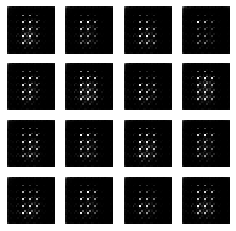

Time for epoch 1 is 783.7224831581116 sec


In [0]:
%%time
train(train_dataset, EPOCHS)

마지막 체크포인트를 복구합니다.

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## GIF 생성

In [0]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
display_image(EPOCHS)

`imageio`로 훈련 중에 저장된 이미지를 사용해 GIF 애니메이션을 만듭니다.

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

코랩에서 작업하고 있다면, 아래의 코드에서 애니메이션을 다운로드 받을 수 있습니다: 

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

## 다음 단계

이 튜토리얼은 생성적 적대 신경망을 만들고 훈련하기에 필요한 코드를 보여줍니다. 다음 단계로, 다른 데이터셋을 이용하여 실험해보고 싶을 수도 있습니다. 예를 들면 [캐글에 올라온](https://www.kaggle.com/jessicali9530/celeba-dataset/home) 대규모 연예인 얼굴 데이터셋 (Large-scale Celeb Faces Attributes (CelebA))이 있습니다. 생성적 적대 신경망에 대해 더 배우기 원한다면, [NIPS 2016 튜토리얼: 생성적 적대 신경망](https://arxiv.org/abs/1701.00160)을 추천합니다.